# Choosing Appropriate Function to Minimise in PNA

*Author: Maleakhi Agung Wijaya  
Date Created: 09/01/2018
*

In [10]:
import random
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, clear_output
import dill

In [11]:
dill.dump_session('notebook_env.db') # to save session

In [ ]:
dill.load_session('notebook_env.db') # to load session

## Mountain Car Environment

In [11]:
class MountainCarEnvironment:
    """
    Description: Environment for Mountain Car problem, adapted from Sutton and Barto's Introduction to Reinforcement Learning.
    Author: Maleakhi Agung Wijaya
    """
    VELOCITY_BOUNDARIES = (-0.07, 0.07)
    POSITION_BOUNDARIES = (-1.2, 0.6) 
    
    INITIAL_VELOCITY = 0.0
    INITIAL_POSITION = -0.5
    
    REWARD_STEP = -1
    REWARD_TERMINAL = 0
   
    # Constructor for MountainCarEnvironment
    # Input: agent for the MountainCarEnvironment
    # Output: MountainCarEnvironment object
    def __init__(self, car):
        self.car = car
        self.reset()
        
    # Compute next state (feature)
    # Output: [new velocity, new position]
    def nextState(self, action):
        # Get current state (velocity, position) and the action chosen by the agent
        velocity = self.car.state[0]
        position = self.car.state[1]
        
        # Calculate the new velocity and new position
        velocity += action * 0.001 + math.cos(3*position) * (-0.0025)
        # Consider boundary for velocity
        if (velocity < MountainCarEnvironment.VELOCITY_BOUNDARIES[0]):
            velocity = MountainCarEnvironment.VELOCITY_BOUNDARIES[0]
        elif (velocity > MountainCarEnvironment.VELOCITY_BOUNDARIES[1]):
            velocity = MountainCarEnvironment.VELOCITY_BOUNDARIES[1]
            
        position += velocity
        # Consider boundary for position
        if (position < MountainCarEnvironment.POSITION_BOUNDARIES[0]):
            position = MountainCarEnvironment.POSITION_BOUNDARIES[0]
            velocity = 0
        elif (position > MountainCarEnvironment.POSITION_BOUNDARIES[1]):
            position = MountainCarEnvironment.POSITION_BOUNDARIES[1]
        
        new_state = [velocity, position]
        return(new_state)
    
    # Reset to the initial state   
    def reset(self):
        self.car.state[0] = MountainCarEnvironment.INITIAL_VELOCITY
        self.car.state[1] = MountainCarEnvironment.INITIAL_POSITION
        
    # Give reward for each of the chosen action, depending on what the next state that the agent end up in
    # Output: terminal state = 0, non-terminal state = -1
    def calculateReward(self):
        # Get current position of the agent
        position = self.car.state[1]
        
        # Determine the reward given
        if (position >= MountainCarEnvironment.POSITION_BOUNDARIES[1]):
            return(MountainCarEnvironment.REWARD_TERMINAL)
        else:
            return(MountainCarEnvironment.REWARD_STEP)

## PNA Agent Algorithm with Choosing Lowest Variance

In [16]:
class PNAAgent:
    """
    Description: Mountain Car problem agent based on PNA algorithm adapted from Marcus Hutter's literatures
    Author: Maleakhi Agung Wijaya
    """
    INITIAL_VELOCITY = 0.0
    INITIAL_POSITION = -0.5
    INITIAL_VALUE = -1
    
    ACTIONS = [-1, 0, 1]
    GAMMA = 0.995
    C = 2 # UCB constant
    EPSILON = 0.1
    
    INDEX_DISTANCE = 0
    INDEX_ORIGINAL = 1
    INDEX_WEIGHT = 2
    
    REWARD_STEP = -1
    REWARD_TERMINAL = 0
    
    # Constructor
    # Input: size of the storage for previous Q values
    def __init__(self, size):
        self.state = [PNAAgent.INITIAL_VELOCITY, PNAAgent.INITIAL_POSITION]
        self.q_storage = []
        self.alpha = 1 # choose fixed alpha, but we will vary alpha later
        
        # Storage of the k nearest neighbour (data) and weight (inverse of distance) for a particular step
        self.knn = []
        self.weight = []
        self.k_history = [] # used to store history of k chosen for each action
        
        self.var_function_left = []
        self.var_function_neutral = []
        self.var_function_right = []
        
        # Initialise the storage with random point 
        for i in range(size):
            initial_value = PNAAgent.INITIAL_VALUE
            initial_action = random.randint(-1, 1)
            initial_state = [random.uniform(-0.07, 0.07), random.uniform(-1.2, 0.6)]
            
            if (initial_action == -1):
                self.var_function_left.append(0)
            elif (initial_action == 0):
                self.var_function_neutral.append(0)
            else:
                self.var_function_right.append(0)
            
            # Each data on the array will consist of state, action pair + value
            data = {"state": initial_state, "value": initial_value, "action": initial_action}
            self.q_storage.append(data)
        
        self.var_function_left.pop()
        self.var_function_neutral.pop()
        self.var_function_right.pop()
    
    # Standardise feature vector given
    # Input: feature vector to be standardised
    # Output: standardised feature vector
    def standardiseState(self, state):
        standardised_state = []
        standardised_velocity = 2 * ((state[0]+0.07) / (0.07+0.07)) - 1
        standardised_position = 2 * ((state[1]+1.2) / (0.6+1.2)) - 1
        standardised_state.append(standardised_velocity)
        standardised_state.append(standardised_position)
        
        return(standardised_state)
    
    # Find all index for a given value
    # Input: value, list to search
    # Output: list of all index where you find that value on the list
    def findAllIndex(self, value, list_value):
        indices = []
        for i in range(len(list_value)):
              if (value == list_value[i]):
                    indices.append(i)
        
        return indices
    
    # Calculate Euclidean distance between 2 vectors
    # Input: 2 feature vectors
    # Output: distance between them
    def calculateDistance(self, vector1, vector2):
        return(math.sqrt((vector1[0]-vector2[0])**2 + (vector1[1]-vector2[1])**2))
    
    # Calculate total weight
    # Input: list of weights
    # Output: total weight
    def calculateTotalWeight(self, weight_list):
        total_weight = 0
        for i in range(len(weight_list)):
            total_weight += weight_list[i][PNAAgent.INDEX_WEIGHT]
        
        return(total_weight)
            
    # Clear the knn list, k_history, and also the weight list
    def cleanList(self):
        self.knn = []
        self.weight = []
        self.k_history = []
    
    # Choose the appropriate k by minimising variance and maximising the number of data to learn
    # Input: sorted neighbourhood list based on distance (distance, index, weight)
    # Output: k (numbers of nearest neighbour) that minimise neighbourhood variance function
    def chooseK(self, neighbourhood_list):
        data_list = []
        
        action = 0
        # Extract the data (Q value from the neighbourhood_list) and append it to the data_list
        for data in neighbourhood_list:
            data_list.append(self.q_storage[data[PNAAgent.INDEX_ORIGINAL]]["value"])
            action = self.q_storage[data[PNAAgent.INDEX_ORIGINAL]]["action"]
            
        # Initialise minimum variance
        minimum_k = 2 # Variable that will be return that minimise the variance of the neighbourhood
        minimum_function = np.var(data_list[:2])
        
        list_var = []
        if (action == -1):
            list_var = self.var_function_left
        elif (action == 0):
            list_var = self.var_function_neutral
        else:
            list_var = self.var_function_right
        
        list_var[0] += minimum_function
        
        previous_sum_variance = np.var(data_list[:2]) * 2
        previous_mean = np.mean(data_list[:2])
        k = 2
        # Iterate to find optimal k that will minimise the neighbourhood variance function
        for i in range(2, len(neighbourhood_list)):
            target_x = data_list[i]
            mean = (previous_mean * k + target_x) / (k + 1)
            current_sum_variance = previous_sum_variance + (target_x - previous_mean) * (target_x - mean)
            
            # Update for next iteration
            k = k + 1
            previous_sum_variance = current_sum_variance
            previous_mean = mean
            
            function = current_sum_variance / k
            list_var[k-2] += function
            # Update the k value and minimum var value if find parameter which better minimise than the previous value
            if (function <= minimum_function):
                minimum_k = k
                minimum_function = function
            
        return(minimum_k)
    
    # PNA variance function that needed to be minimise
    # Input: constant c, list containing data points
    # Output: calculation result from the neighbourhood variance function
    def neighbourhoodVariance(self, c, data_list, var = None, k = None):
        if (var == None):
            return(math.sqrt(c * np.var(data_list) / len(data_list)))
        else:
            return(math.sqrt(c * var / k))
    
    # Get starting index for the weight list
    # Input: action, k_history
    # Output: starting index for the weight list
    def getStartingIndex(self, action, k_history):
        count_action = action + 1
        if (count_action == 0):
            return(0)
        else:
            index = 0
            for i in range(count_action):
                index += k_history[i]
            return(index)
        
    # Apply the PNA algorithm for feature vector and store the data point on the neighbours array
    # Input: feature vector of current state, actions array consisting of all possible actions, list that will store knn data and weights data, k_history
    # Output: vector containing the value of taking each action (left, neutral, right)
    def PNA(self, state, actions, knn_list, weight_list, k_history):
        approximate_action = []
        
        # Get the standardised version of state
        standardised_state = self.standardiseState(state)
        
        # Loop through every element in the storage array and only calculate for particular action
        for action in actions:
            temp = [] # array consisting of tuple (distance, original index, weight) for each point in the q_storage
            for i in range(len(self.q_storage)):
                data = self.q_storage[i]
                # Only want to calculate the nearest neighbour state which has the same action
                if (data["action"] == action):
                    vector_2 = data["state"]
                    standardised_vector_2 = self.standardiseState(vector_2)
                    distance = self.calculateDistance(standardised_state, standardised_vector_2)
                    index = i
                    weight = 1 / (1+distance**2)
            
                    # Create the tuple and append that to temp
                    temp.append(tuple((distance, index, weight)))
                else:
                    continue
            
            # After we finish looping through all of the point and calculating the standardise distance,
            # Sort the tuple based on the distance and only take k of it and append that to the neighbours array
            sorted_temp = sorted(temp, key=lambda x: x[0])
            # Get the value of the k dynamically
            k = self.chooseK(sorted_temp)
            k_history.append(k)
            
            for i in range(k):
                try:
                    weight_list.append(sorted_temp[i])
                    knn_list.append(self.q_storage[sorted_temp[i][PNAAgent.INDEX_ORIGINAL]])
                except IndexError:
                    sys.exit(0)
            
            # Calculate the expected value of the action and append it to the approximate_action array
            expected_value = 0
            # We also need to calculate the total weight to make it into valid probability that we can compute it's expectation
            total_weight = self.calculateTotalWeight(weight_list[self.getStartingIndex(action, k_history):self.getStartingIndex(action, k_history)+k])
            for i in range(self.getStartingIndex(action, k_history), self.getStartingIndex(action, k_history) + k):
                try:
                    weight = weight_list[i][PNAAgent.INDEX_WEIGHT]
                    probability = weight / total_weight
                    expected_value += probability * knn_list[i]["value"]
                except IndexError:
                    sys.exit(0)
                    
            approximate_action.append(expected_value)
        
        return(approximate_action)
    
    # Calculate TD target based on Q Learning/ SARSAMAX
    # Input: Immediate reward based on what the environment gave
    # Output: TD target based on off policy Q learning
    def calculateTDTarget(self, immediate_reward):
        # Condition if final state
        if (immediate_reward == PNAAgent.REWARD_TERMINAL):
            return(immediate_reward)
        
        k_history = []
        knn_prime = []
        weight_prime = []
        action_value = self.PNA(self.state, PNAAgent.ACTIONS, knn_prime, weight_prime, k_history)
        
        return(immediate_reward + PNAAgent.GAMMA * max(action_value))
    
    # Q learning TD updates on every neighbours on the kNN based on the contribution that are calculated using probability weight
    # Input: Immediate reward based on what the environment gave
    def TDUpdate(self, immediate_reward, alpha):
        self.alpha = alpha
        # First, calculate the TD target
        td_target = self.calculateTDTarget(immediate_reward)
        
        # Iterate every kNN and update using Q learning method based on the weighting
        total_weight = self.calculateTotalWeight(self.weight)
        for i in range(len(self.weight)):
            index = self.weight[i][PNAAgent.INDEX_ORIGINAL]
            probability = self.weight[i][PNAAgent.INDEX_WEIGHT] / total_weight
            
            # Begin updating
            td_error = td_target - self.q_storage[index]["value"]
            self.q_storage[index]["value"] = self.q_storage[index]["value"] + self.alpha*td_error*probability
        
        self.cleanList() # clean list to prepare for another step
    
    # Getting the maximum of the ucb method
    # Input: action_value list, bonus_variance list
    # Output: action which maximise
    def maximumUCB(self, action_value, bonus_variance):
        max_index = 0
        max_value = action_value[0] + bonus_variance[0]
        
        # Check 1, 2 (all possible action)
        for i in range(1, 3):
            value = action_value[i] + bonus_variance[i]
            
            if (value >= max_value):
                max_value = value
                max_index = i
        
        return(max_index - 1) # return the action which maximise
        
    # Select which action to choose, whether left, neutral, or right (using UCB)
    # Output: -1 (left), 0 (neutral), 1 (right)
    def selectAction(self):
        action_value = self.PNA(self.state, PNAAgent.ACTIONS, self.knn, self.weight, self.k_history)
        
        # Second term of ucb, calculate the bonus variance
        bonus_variance = []
        start_index = [] # used to calculate start index for each action
        finish_index = [] # used to calculate end index for each action
        for action in PNAAgent.ACTIONS:
            data_list = []
            # Prevent index out of bound
            if (action != 1):
                # Data extraction
                start_index.append(self.getStartingIndex(action, self.k_history))
                finish_index.append(self.getStartingIndex(action+1, self.k_history))
            else:
                # Data extraction
                start_index.append(self.getStartingIndex(action, self.k_history))
                finish_index.append(len(self.weight))
            
            # Appending the data and the bonus variance for particular actions
            for i in range(start_index[-1], finish_index[-1]):
                data_list.append(self.q_storage[self.weight[i][PNAAgent.INDEX_ORIGINAL]]["value"])
            bonus_variance.append(self.neighbourhoodVariance(PNAAgent.C, data_list))
                
        # Choose the action based on ucb method
        action_chosen = self.maximumUCB(action_value, bonus_variance)

        # Use the epsilon-greedy method to choose value
        random_number = random.uniform(0.0, 1.0)
        if (random_number <= PNAAgent.EPSILON):
            action_chosen = random.randint(-1, 1)
        else:
            # Return the action with highest Q(s,a)
            possible_index = self.findAllIndex(max(action_value), action_value)
            action_chosen = possible_index[random.randrange(len(possible_index))] - 1
                               
        # Only store chosen data in the knn and weight list
        # Clearance step
        chosen_knn = []
        chosen_weight = []
        for i in range(start_index[action_chosen+1], finish_index[action_chosen+1]):
            chosen_knn.append(self.knn[i])
            chosen_weight.append(self.weight[i])
        self.knn = chosen_knn
        self.weight = chosen_weight
        
        return action_chosen

## Main Function

In [21]:
# Generate decaying alphas
# Input: minimum alpha, number of episodes
# Output: list containing alpha
def generateAlphas(minimum_alpha, n_episodes):
    return(np.linspace(1.0, MIN_ALPHA, N_EPISODES))

N_EPISODES = 50
MIN_ALPHA = 0.02
alphas = generateAlphas(MIN_ALPHA, N_EPISODES)

In [22]:
# Initialise the environment and the agent
size = 1000 # size of the q_storage 
agent = PNAAgent(size)
mountain_car_environment = MountainCarEnvironment(agent)

# Used for graphing purposes
count_step = [] # counter for how many step in each episodes
trajectories = []

k_first_left = []
k_first_neutral = []
k_first_right = []

k_last_left = []
k_last_neutral = []
k_last_right = []

k_general = []

In [23]:
# Iterate the process, train the agent (training_iteration episodes)
training_iteration = N_EPISODES
total_step = 0
for i in range(training_iteration):
    step = 0
    alpha = alphas[i]
    mountain_car_environment.reset()
    while (True):
        action = agent.selectAction()
        k_general.append(agent.k_history[action + 1])
        next_state = mountain_car_environment.nextState(action)
        
        # Change agent current state and getting reward
        agent.state = next_state
        immediate_reward = mountain_car_environment.calculateReward()
        
        # Used for graphing
        step += 1
        total_step += 1
        trajectories.append(next_state[1])
        
        # Only append first and last episode (for the k)
        if (i == 1):
            k_first_left.append(agent.k_history[0])
            k_first_neutral.append(agent.k_history[1])
            k_first_right.append(agent.k_history[2])
        if (i == (training_iteration - 1)):
            k_last_left.append(agent.k_history[0])
            k_last_neutral.append(agent.k_history[1])
            k_last_right.append(agent.k_history[2])
        
        # Test for successful learning
        if (immediate_reward == MountainCarEnvironment.REWARD_TERMINAL):
            agent.TDUpdate(immediate_reward, alpha)
            count_step.append(step)
            
            clear_output(wait=True) # clear previous output
            # Create table
            d = {"Steps": count_step}
            episode_table = pd.DataFrame(data=d, index=np.arange(1, len(count_step)+1))
            episode_table.index.names = ['Episodes']
            display(episode_table)
            break
        
        # Prevent divergent
        if (step > 200000):
            sys.exit(0)
            
        # Update using Q Learning and kNN
        agent.TDUpdate(immediate_reward, alpha)

,Steps
Episodes,
1,5175
2,2481
3,1432
4,563
5,1521
6,1018
7,1025
8,1182
9,1233


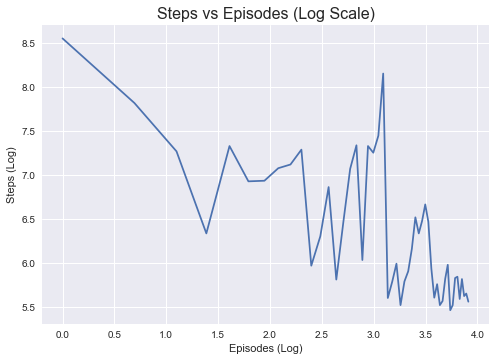

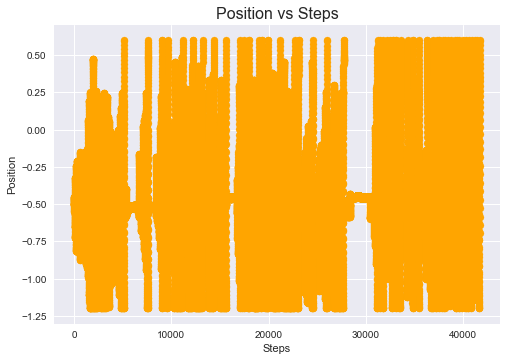

In [29]:
# Create graph for step vs episodes
y = np.log(count_step)
x = np.log(np.arange(1, len(y) + 1))

plt.plot(x, y)
plt.title("Steps vs Episodes (Log Scale)", fontsize=16)
plt.xlabel("Episodes (Log)")
plt.ylabel("Steps (Log)")

plt.show()

# Create graph for position vs step
y2 = trajectories
x2 = np.arange(1, len(y2) + 1)
plt.scatter(x2, y2, color="orange")
plt.title("Position vs Steps", fontsize=16)
plt.xlabel("Steps")
plt.ylabel("Position")

plt.show()

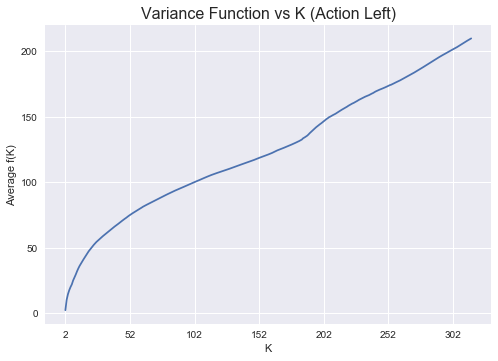

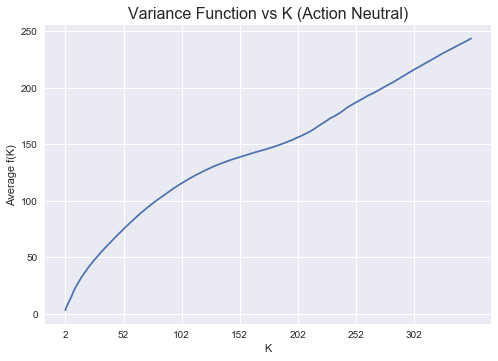

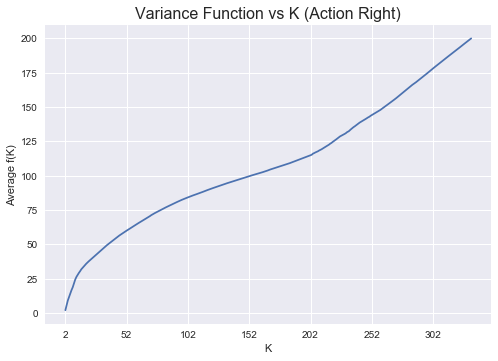

In [25]:
average_var_left = []
average_var_neutral = []
average_var_right = []

for elem in agent.var_function_left:
    average_var_left.append(elem/ total_step)

for elem in agent.var_function_neutral:
    average_var_neutral.append(elem/ total_step)

for elem in agent.var_function_right:
    average_var_right.append(elem/ total_step)

# Make a scatter plot
# Left
y = average_var_left
x = np.arange(2, len(y)+2)

plt.plot(x, y)
plt.title("Variance Function vs K (Action Left)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()

# Make a scatter plot
# Neutral
y = average_var_neutral
x = np.arange(2, len(y)+2)

plt.plot(x, y)
plt.title("Variance Function vs K (Action Neutral)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()


# Make a scatter plot
# Right
y = average_var_right
x = np.arange(2, len(y)+2)

plt.plot(x, y)
plt.title("Variance Function vs K (Action Right)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()

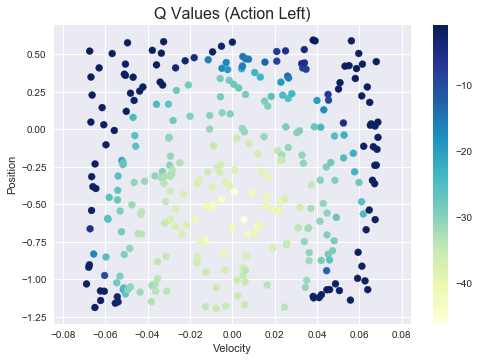

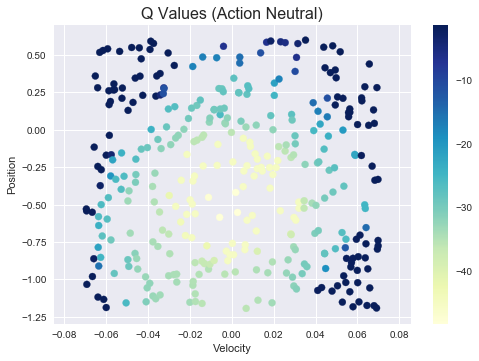

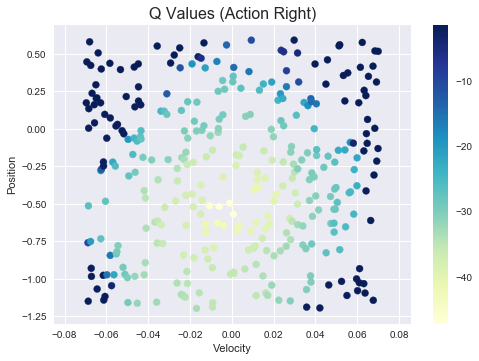

In [26]:
# Create heatmap for Q values
data = pd.DataFrame()
data_left = []
data_neutral = []
data_right = []

position_left = []
position_neutral = []
position_right = []

velocity_left = []
velocity_neutral = []
velocity_right = []

# Sort q_storage based on position and velocity
q_storage_sorted = sorted(agent.q_storage, key=lambda k: k['state'][0])  
# Separate action left, neutral, and right
for elem in q_storage_sorted:
    if (elem["action"] == -1):
        data_left.append(elem["value"])
        position_left.append(elem["state"][1])
        velocity_left.append(elem["state"][0])
    elif (elem["action"] == 0):
        data_neutral.append(elem["value"])
        position_neutral.append(elem["state"][1])
        velocity_neutral.append(elem["state"][0])
    else:
        data_right.append(elem["value"])
        position_right.append(elem["state"][1])
        velocity_right.append(elem["state"][0])

# Make scatter plot for 3 actions (left, neutral, right)
# Left
plt.scatter(x=velocity_left, y=position_left, c=data_left, cmap="YlGnBu")
plt.title("Q Values (Action Left)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

# Neutral
plt.scatter(x=velocity_neutral, y=position_neutral, c=data_neutral, cmap="YlGnBu")
plt.title("Q Values (Action Neutral)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

# Right
plt.scatter(x=velocity_right, y=position_right, c=data_right, cmap="YlGnBu")
plt.title("Q Values (Action Right)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

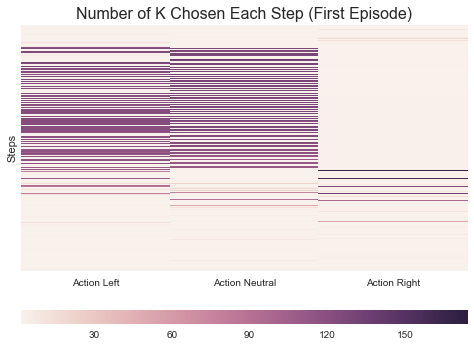

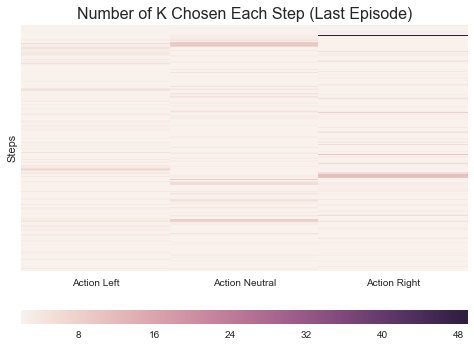

In [28]:
# Create heatmap showing the k (first episode)
data = pd.DataFrame()
data["Action Left"] = k_first_left
data["Action Neutral"] = k_first_neutral
data["Action Right"] = k_first_right
data["Steps"] = np.arange(1, len(k_first_left) + 1)
data.set_index("Steps", inplace=True)

grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(data, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, yticklabels=False)
ax.set_title("Number of K Chosen Each Step (First Episode)", fontsize=16)

plt.show()

# Create heatmap showing the k (last episode)
data = pd.DataFrame()
data["Action Left"] = k_last_left
data["Action Neutral"] = k_last_neutral
data["Action Right"] = k_last_right
data["Steps"] = np.arange(1, len(k_last_left) + 1)
data.set_index("Steps", inplace=True)

grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(data, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, yticklabels=False)
ax.set_title("Number of K Chosen Each Step (Last Episode)", fontsize=16)

plt.show()

## PNA Algorithm with Choosing Using Std Error

In [12]:
class PNAAgent:
    """
    Description: Mountain Car problem agent based on PNA algorithm adapted from Marcus Hutter's literatures
    Author: Maleakhi Agung Wijaya
    """
    INITIAL_VELOCITY = 0.0
    INITIAL_POSITION = -0.5
    INITIAL_VALUE = -1
    
    ACTIONS = [-1, 0, 1]
    GAMMA = 0.995
    C = 2 # UCB constant
    EPSILON = 0.1
    
    INDEX_DISTANCE = 0
    INDEX_ORIGINAL = 1
    INDEX_WEIGHT = 2
    
    REWARD_STEP = -1
    REWARD_TERMINAL = 0
    
    # Constructor
    # Input: size of the storage for previous Q values
    def __init__(self, size):
        self.state = [PNAAgent.INITIAL_VELOCITY, PNAAgent.INITIAL_POSITION]
        self.q_storage = []
        self.alpha = 1 # choose fixed alpha, but we will vary alpha later
        
        # Storage of the k nearest neighbour (data) and weight (inverse of distance) for a particular step
        self.knn = []
        self.weight = []
        self.k_history = [] # used to store history of k chosen for each action
        
        self.var_function_left = []
        self.var_function_neutral = []
        self.var_function_right = []
        
        # Initialise the storage with random point 
        for i in range(size):
            initial_value = PNAAgent.INITIAL_VALUE
            initial_action = random.randint(-1, 1)
            initial_state = [random.uniform(-0.07, 0.07), random.uniform(-1.2, 0.6)]
            
            if (initial_action == -1):
                self.var_function_left.append(0)
            elif (initial_action == 0):
                self.var_function_neutral.append(0)
            else:
                self.var_function_right.append(0)
            
            # Each data on the array will consist of state, action pair + value
            data = {"state": initial_state, "value": initial_value, "action": initial_action}
            self.q_storage.append(data)
        
        self.var_function_left.pop()
        self.var_function_neutral.pop()
        self.var_function_right.pop()
    
    # Find all index for a given value
    # Input: value, list to search
    # Output: list of all index where you find that value on the list
    def findAllIndex(self, value, list_value):
        indices = []
        for i in range(len(list_value)):
              if (value == list_value[i]):
                    indices.append(i)
        
        return indices
    
    # Standardise feature vector given
    # Input: feature vector to be standardised
    # Output: standardised feature vector
    def standardiseState(self, state):
        standardised_state = []
        standardised_velocity = 2 * ((state[0]+0.07) / (0.07+0.07)) - 1
        standardised_position = 2 * ((state[1]+1.2) / (0.6+1.2)) - 1
        standardised_state.append(standardised_velocity)
        standardised_state.append(standardised_position)
        
        return(standardised_state)
    
    # Calculate Euclidean distance between 2 vectors
    # Input: 2 feature vectors
    # Output: distance between them
    def calculateDistance(self, vector1, vector2):
        return(math.sqrt((vector1[0]-vector2[0])**2 + (vector1[1]-vector2[1])**2))
    
    # Calculate total weight
    # Input: list of weights
    # Output: total weight
    def calculateTotalWeight(self, weight_list):
        total_weight = 0
        for i in range(len(weight_list)):
            total_weight += weight_list[i][PNAAgent.INDEX_WEIGHT]
        
        return(total_weight)
            
    # Clear the knn list, k_history, and also the weight list
    def cleanList(self):
        self.knn = []
        self.weight = []
        self.k_history = []
    
    # Choose the appropriate k by minimising variance and maximising the number of data to learn
    # Input: sorted neighbourhood list based on distance (distance, index, weight)
    # Output: k (numbers of nearest neighbour) that minimise neighbourhood variance function
    def chooseK(self, neighbourhood_list):
        data_list = []
        action = 0
        # Extract the data (Q value from the neighbourhood_list) and append it to the data_list
        for data in neighbourhood_list:
            data_list.append(self.q_storage[data[PNAAgent.INDEX_ORIGINAL]]["value"])
            action = self.q_storage[data[PNAAgent.INDEX_ORIGINAL]]["action"]
            
        # Initialise minimum variance
        minimum_k = 2 # Variable that will be return that minimise the variance of the neighbourhood
        minimum_function = self.neighbourhoodVariance(1, data_list[:2])
        
        list_var = []
        if (action == -1):
            list_var = self.var_function_left
        elif (action == 0):
            list_var = self.var_function_neutral
        else:
            list_var = self.var_function_right
        
        list_var[0] += minimum_function
        
        previous_sum_variance = np.var(data_list[:2]) * 2
        previous_mean = np.mean(data_list[:2])
        k = 2
        # Iterate to find optimal k that will minimise the neighbourhood variance function
        for i in range(2, len(neighbourhood_list)):
            target_x = data_list[i]
            mean = (previous_mean * k + target_x) / (k + 1)
            current_sum_variance = previous_sum_variance + (target_x - previous_mean) * (target_x - mean)
            
            # Update for next iteration
            k = k + 1
            previous_sum_variance = current_sum_variance
            previous_mean = mean
            
            function = self.neighbourhoodVariance(1, [], current_sum_variance/k, k)
            list_var[k-2] += function
            # Update the k value and minimum var value if find parameter which better minimise than the previous value
            if (function <= minimum_function):
                minimum_k = k
                minimum_function = function
            
        return(minimum_k)
    
    # PNA variance function that needed to be minimise
    # Input: constant c, list containing data points
    # Output: calculation result from the neighbourhood variance function
    def neighbourhoodVariance(self, c, data_list, var = None, k = None):
        if (var == None):
            return(math.sqrt(c * np.var(data_list) / len(data_list)))
        else:
            return(math.sqrt(c * var / k))
    
    # Get starting index for the weight list
    # Input: action, k_history
    # Output: starting index for the weight list
    def getStartingIndex(self, action, k_history):
        count_action = action + 1
        if (count_action == 0):
            return(0)
        else:
            index = 0
            for i in range(count_action):
                index += k_history[i]
            return(index)
        
    # Apply the PNA algorithm for feature vector and store the data point on the neighbours array
    # Input: feature vector of current state, actions array consisting of all possible actions, list that will store knn data and weights data, k_history
    # Output: vector containing the value of taking each action (left, neutral, right)
    def PNA(self, state, actions, knn_list, weight_list, k_history):
        approximate_action = []
        
        # Get the standardised version of state
        standardised_state = self.standardiseState(state)
        
        # Loop through every element in the storage array and only calculate for particular action
        for action in actions:
            temp = [] # array consisting of tuple (distance, original index, weight) for each point in the q_storage
            for i in range(len(self.q_storage)):
                data = self.q_storage[i]
                # Only want to calculate the nearest neighbour state which has the same action
                if (data["action"] == action):
                    vector_2 = data["state"]
                    standardised_vector_2 = self.standardiseState(vector_2)
                    distance = self.calculateDistance(standardised_state, standardised_vector_2)
                    index = i
                    weight = 1 / (1+distance**2)
            
                    # Create the tuple and append that to temp
                    temp.append(tuple((distance, index, weight)))
                else:
                    continue
            
            # After we finish looping through all of the point and calculating the standardise distance,
            # Sort the tuple based on the distance and only take k of it and append that to the neighbours array
            sorted_temp = sorted(temp, key=lambda x: x[0])
            # Get the value of the k dynamically
            k = self.chooseK(sorted_temp)
            k_history.append(k)
            
            for i in range(k):
                try:
                    weight_list.append(sorted_temp[i])
                    knn_list.append(self.q_storage[sorted_temp[i][PNAAgent.INDEX_ORIGINAL]])
                except IndexError:
                    sys.exit(0)
            
            # Calculate the expected value of the action and append it to the approximate_action array
            expected_value = 0
            # We also need to calculate the total weight to make it into valid probability that we can compute it's expectation
            total_weight = self.calculateTotalWeight(weight_list[self.getStartingIndex(action, k_history):self.getStartingIndex(action, k_history)+k])
            for i in range(self.getStartingIndex(action, k_history), self.getStartingIndex(action, k_history) + k):
                try:
                    weight = weight_list[i][PNAAgent.INDEX_WEIGHT]
                    probability = weight / total_weight
                    expected_value += probability * knn_list[i]["value"]
                except IndexError:
                    sys.exit(0)
                    
            approximate_action.append(expected_value)
        
        return(approximate_action)
    
    # Calculate TD target based on Q Learning/ SARSAMAX
    # Input: Immediate reward based on what the environment gave
    # Output: TD target based on off policy Q learning
    def calculateTDTarget(self, immediate_reward):
        # Condition if final state
        if (immediate_reward == PNAAgent.REWARD_TERMINAL):
            return(immediate_reward)
        
        k_history = []
        knn_prime = []
        weight_prime = []
        action_value = self.PNA(self.state, PNAAgent.ACTIONS, knn_prime, weight_prime, k_history)
        
        return(immediate_reward + PNAAgent.GAMMA * max(action_value))
    
    # Q learning TD updates on every neighbours on the kNN based on the contribution that are calculated using probability weight
    # Input: Immediate reward based on what the environment gave
    def TDUpdate(self, immediate_reward, alpha):
        self.alpha = alpha
        # First, calculate the TD target
        td_target = self.calculateTDTarget(immediate_reward)
        
        # Iterate every kNN and update using Q learning method based on the weighting
        total_weight = self.calculateTotalWeight(self.weight)
        for i in range(len(self.weight)):
            index = self.weight[i][PNAAgent.INDEX_ORIGINAL]
            probability = self.weight[i][PNAAgent.INDEX_WEIGHT] / total_weight
            
            # Begin updating
            td_error = td_target - self.q_storage[index]["value"]
            self.q_storage[index]["value"] = self.q_storage[index]["value"] + self.alpha*td_error*probability
        
        self.cleanList() # clean list to prepare for another step
    
    # Getting the maximum of the ucb method
    # Input: action_value list, bonus_variance list
    # Output: action which maximise
    def maximumUCB(self, action_value, bonus_variance):
        max_index = 0
        max_value = action_value[0] + bonus_variance[0]
        
        # Check 1, 2 (all possible action)
        for i in range(1, 3):
            value = action_value[i] + bonus_variance[i]
            
            if (value >= max_value):
                max_value = value
                max_index = i
        
        return(max_index - 1) # return the action which maximise
        
    # Select which action to choose, whether left, neutral, or right (using UCB)
    # Output: -1 (left), 0 (neutral), 1 (right)
    def selectAction(self):
        action_value = self.PNA(self.state, PNAAgent.ACTIONS, self.knn, self.weight, self.k_history)
        
        # Second term of ucb, calculate the bonus variance
        bonus_variance = []
        start_index = [] # used to calculate start index for each action
        finish_index = [] # used to calculate end index for each action
        for action in PNAAgent.ACTIONS:
            data_list = []
            # Prevent index out of bound
            if (action != 1):
                # Data extraction
                start_index.append(self.getStartingIndex(action, self.k_history))
                finish_index.append(self.getStartingIndex(action+1, self.k_history))
            else:
                # Data extraction
                start_index.append(self.getStartingIndex(action, self.k_history))
                finish_index.append(len(self.weight))
            
            # Appending the data and the bonus variance for particular actions
            for i in range(start_index[-1], finish_index[-1]):
                data_list.append(self.q_storage[self.weight[i][PNAAgent.INDEX_ORIGINAL]]["value"])
            bonus_variance.append(self.neighbourhoodVariance(PNAAgent.C, data_list))
                
        # Choose the action based on ucb method
        action_chosen = self.maximumUCB(action_value, bonus_variance)
        
        # Use the epsilon-greedy method to choose value
        random_number = random.uniform(0.0, 1.0)
        if (random_number <= PNAAgent.EPSILON):
            action_chosen = random.randint(-1, 1)
        else:
            # Return the action with highest Q(s,a)
            possible_index = self.findAllIndex(max(action_value), action_value)
            action_chosen = possible_index[random.randrange(len(possible_index))] - 1
                               
        # Only store chosen data in the knn and weight list
        # Clearance step
        chosen_knn = []
        chosen_weight = []
        for i in range(start_index[action_chosen+1], finish_index[action_chosen+1]):
            chosen_knn.append(self.knn[i])
            chosen_weight.append(self.weight[i])
        self.knn = chosen_knn
        self.weight = chosen_weight
        
        return action_chosen

## Main Function

In [13]:
# Generate decaying alphas
# Input: minimum alpha, number of episodes
# Output: list containing alpha
def generateAlphas(minimum_alpha, n_episodes):
    return(np.linspace(1.0, MIN_ALPHA, N_EPISODES))

N_EPISODES = 1000
MIN_ALPHA = 0.02
alphas = generateAlphas(MIN_ALPHA, N_EPISODES)

In [14]:
# Initialise the environment and the agent
size = 1000 # size of the q_storage 
agent = PNAAgent(size)
mountain_car_environment = MountainCarEnvironment(agent)

# Used for graphing purposes
count_step = [] # counter for how many step in each episodes
trajectories = []

k_first_left = []
k_first_neutral = []
k_first_right = []

k_last_left = []
k_last_neutral = []
k_last_right = []

k_general = []

In [ ]:
# Iterate the process, train the agent (training_iteration episodes)
training_iteration = N_EPISODES
total_step = 0
for i in range(training_iteration):
    step = 0
    alpha = alphas[i]
    mountain_car_environment.reset()
    while (True):
        action = agent.selectAction()
        k_general.append(agent.k_history[action + 1])
        next_state = mountain_car_environment.nextState(action)
        
        # Change agent current state and getting reward
        agent.state = next_state
        immediate_reward = mountain_car_environment.calculateReward()
        
        # Used for graphing
        step += 1
        total_step += 1
        trajectories.append(next_state[1])
        
        # Only append first and last episode (for the k)
        if (i == 1):
            k_first_left.append(agent.k_history[0])
            k_first_neutral.append(agent.k_history[1])
            k_first_right.append(agent.k_history[2])
        if (i == (training_iteration - 1)):
            k_last_left.append(agent.k_history[0])
            k_last_neutral.append(agent.k_history[1])
            k_last_right.append(agent.k_history[2])
        
        # Test for successful learning
        if (immediate_reward == MountainCarEnvironment.REWARD_TERMINAL):
            agent.TDUpdate(immediate_reward, alpha)
            count_step.append(step)
            
            clear_output(wait=True) # clear previous output
            # Create table
            d = {"Steps": count_step}
            episode_table = pd.DataFrame(data=d, index=np.arange(1, len(count_step)+1))
            episode_table.index.names = ['Episodes']
            display(episode_table)
            break
        
        # Prevent divergent
        if (step > 200000):
            sys.exit(0)
            
        # Update using Q Learning and kNN
        agent.TDUpdate(immediate_reward, alpha)

,Steps
Episodes,
1,20374


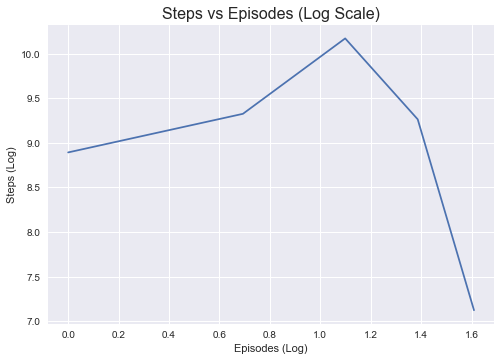

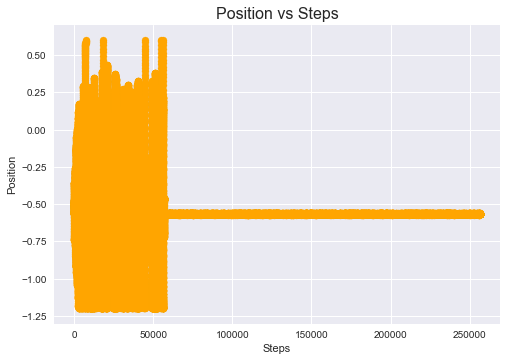

In [7]:
# Create graph for step vs episodes
y = np.log(count_step)
x = np.log(np.arange(1, len(y) + 1))

plt.plot(x, y)
plt.title("Steps vs Episodes (Log Scale)", fontsize=16)
plt.xlabel("Episodes (Log)")
plt.ylabel("Steps (Log)")

plt.show()

# Create graph for position vs step
y2 = trajectories
x2 = np.arange(1, len(y2) + 1)
plt.scatter(x2, y2, color="orange")
plt.title("Position vs Steps", fontsize=16)
plt.xlabel("Steps")
plt.ylabel("Position")

plt.show()

In [9]:
print(k_general)

[334, 336, 330, 4, 3, 3, 4, 3, 2, 4, 2, 3, 2, 3, 2, 2, 3, 2, 330, 330, 336, 330, 336, 336, 336, 330, 336, 330, 336, 330, 336, 330, 330, 336, 330, 336, 330, 330, 336, 330, 336, 336, 336, 330, 336, 330, 336, 330, 336, 330, 336, 330, 336, 330, 336, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 330, 336, 334, 330, 2, 2, 2, 2, 2, 330, 330, 334, 336, 336, 336, 334, 334, 334, 336, 334, 336, 330, 334, 336, 330, 334, 336, 334, 336, 330, 334, 330, 336, 330, 334, 336, 330, 334, 336, 330, 334, 336, 330, 334, 336, 330, 334, 336, 330, 334, 336, 330, 334, 336, 330, 334, 336, 330, 334, 336, 330, 334, 336, 330, 334, 336, 330, 2, 2, 2, 334, 2, 334, 334, 334, 2, 334, 334, 334, 2, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 330, 330, 330, 336, 336, 330, 336, 336, 330, 336, 330, 330, 336, 330, 336, 330, 330, 336, 330, 336, 336, 336, 336, 336, 336, 336, 3, 336, 336, 334, 334, 334, 336, 334, 336, 336, 334

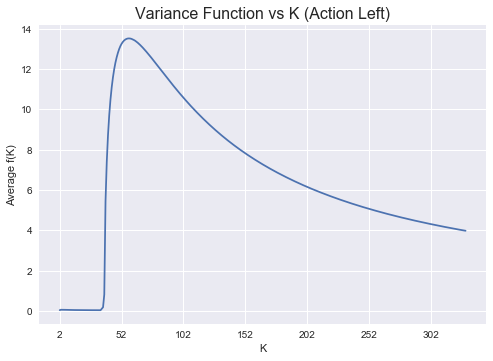

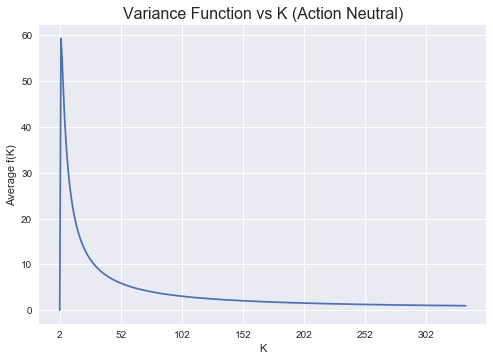

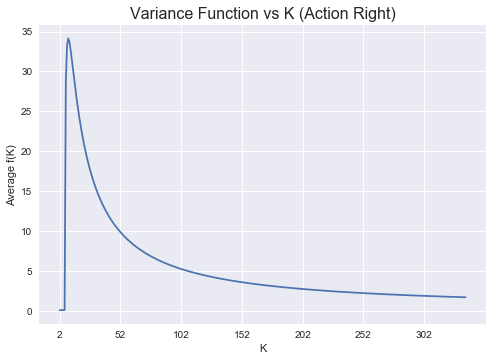

In [8]:
average_var_left = []
average_var_neutral = []
average_var_right = []

for elem in agent.var_function_left:
    average_var_left.append(elem/ total_step)

for elem in agent.var_function_neutral:
    average_var_neutral.append(elem/ total_step)

for elem in agent.var_function_right:
    average_var_right.append(elem/ total_step)

# Make a scatter plot
# Left
y = average_var_left
x = np.arange(2, len(y)+2)

plt.plot(x, y)
plt.title("Variance Function vs K (Action Left)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()

# Make a scatter plot
# Neutral
y = average_var_neutral
x = np.arange(2, len(y)+2)

plt.plot(x, y)
plt.title("Variance Function vs K (Action Neutral)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()


# Make a scatter plot
# Right
y = average_var_right
x = np.arange(2, len(y)+2)

plt.plot(x, y)
plt.title("Variance Function vs K (Action Right)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()

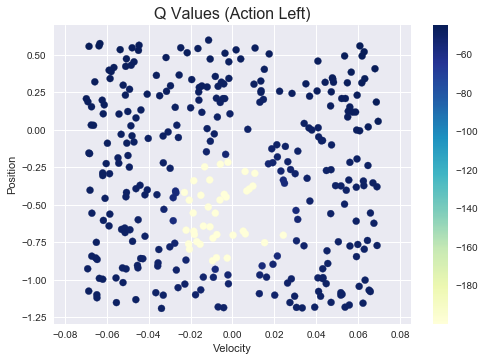

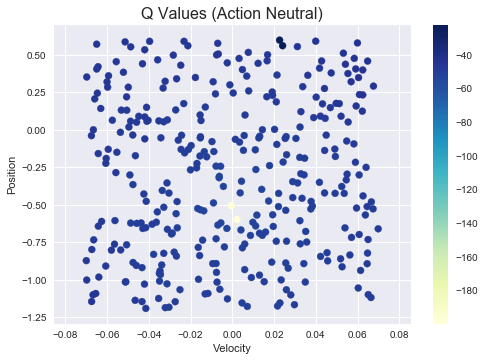

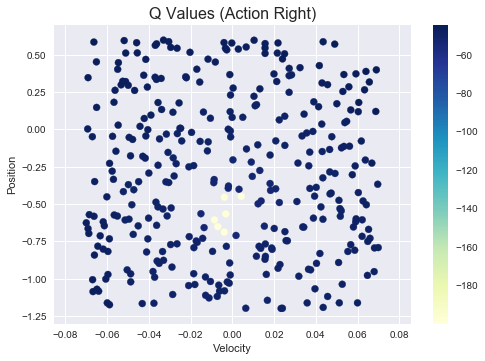

In [10]:
# Create heatmap for Q values
data = pd.DataFrame()
data_left = []
data_neutral = []
data_right = []

position_left = []
position_neutral = []
position_right = []

velocity_left = []
velocity_neutral = []
velocity_right = []

# Sort q_storage based on position and velocity
q_storage_sorted = sorted(agent.q_storage, key=lambda k: k['state'][0])  
# Separate action left, neutral, and right
for elem in q_storage_sorted:
    if (elem["action"] == -1):
        data_left.append(elem["value"])
        position_left.append(elem["state"][1])
        velocity_left.append(elem["state"][0])
    elif (elem["action"] == 0):
        data_neutral.append(elem["value"])
        position_neutral.append(elem["state"][1])
        velocity_neutral.append(elem["state"][0])
    else:
        data_right.append(elem["value"])
        position_right.append(elem["state"][1])
        velocity_right.append(elem["state"][0])

# Make scatter plot for 3 actions (left, neutral, right)
# Left
plt.scatter(x=velocity_left, y=position_left, c=data_left, cmap="YlGnBu")
plt.title("Q Values (Action Left)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

# Neutral
plt.scatter(x=velocity_neutral, y=position_neutral, c=data_neutral, cmap="YlGnBu")
plt.title("Q Values (Action Neutral)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

# Right
plt.scatter(x=velocity_right, y=position_right, c=data_right, cmap="YlGnBu")
plt.title("Q Values (Action Right)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

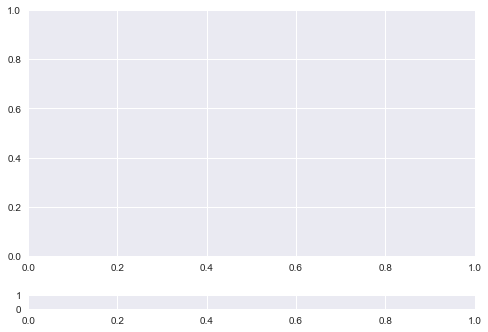

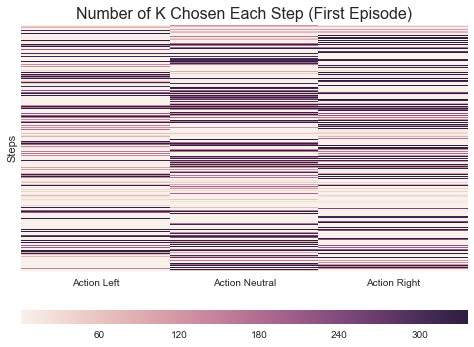

SystemExit: 0

C:\Users\keyst\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
# Create heatmap showing the k (first episode)
data = pd.DataFrame()
data["Action Left"] = k_first_left
data["Action Neutral"] = k_first_neutral
data["Action Right"] = k_first_right
data["Steps"] = np.arange(1, len(k_first_left) + 1)
data.set_index("Steps", inplace=True)

grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(data, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, yticklabels=False)
ax.set_title("Number of K Chosen Each Step (First Episode)", fontsize=16)

plt.show()

# Create heatmap showing the k (last episode)
try:
    data = pd.DataFrame()
    data["Action Left"] = k_last_left
    data["Action Neutral"] = k_last_neutral
    data["Action Right"] = k_last_right
    data["Steps"] = np.arange(1, len(k_last_left) + 1)
    data.set_index("Steps", inplace=True)

    grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
    f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
    ax = sns.heatmap(data, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, yticklabels=False)
    ax.set_title("Number of K Chosen Each Step (Last Episode)", fontsize=16)

    plt.show()
except Exception:
    sys.exit(0)